# **ConvFinQA**



# **The 2  metrics that I will use to evaluate the model will include:**
---
## **1.'Answer' :** Exact-match: This is the final answer output of the model which tests for correctness. This can be assessed using a pass(1) or fail (0).

## **2. 'Program' execution :** Count number of programs called (e.g. add or sub) 1 point each for identify and using. E.g. there are 2 programs needed, it uses both thus 2/2.
---
---

### **Eval**:
- If I'm going to eval it then I need to only provide some examples in prompt, providing the most salient information via the prompt and keys, highlighting some key areas - this will be controlled for.

---
---

### **Hypothesis:**
---

  - **1. Model Testing:** - Running larger models will perform better

  - **2. Basic table difference test:** Putting the tables into html or markdown will improve LLM ability to read table and therefore improve overall metrics.

  - **3. Prompt Engineering** - Will improve performance 

  - **4. Reasoning model** - Will perform better

  - **5.Fine-tuning** - Will improve performance














# 1. Load data & Import Packages

In [372]:
from openai import OpenAI

In [373]:
import json
import os
import re
import random
import pandas as pd
from src.paths import DATA_DIR
from src.models import gpt_4o, gpt_4o_mini, preview_o1

# Ensure dataframe has max with
pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 1000)

# Load the API key from environment variables
api_key = os.getenv("OPENAI_API_KEY")
openai = OpenAI(api_key=api_key)

# Training original data
with open(DATA_DIR / "train.json") as file:
    train_orig = json.load(file)

# 2. Understand data

- "pre_text": the texts before the table;

- "post_text": the text after the table;

- "table": the table;

- "id": unique example id. composed by the original report name plus example
index for this report.

- "qa": {
  - "question": the question;

  - "program": the reasoning program;

  - "gold_inds": the gold supporting facts;

  - "exe_ans": the gold execution result;

  - "program_re": the reasoning program in nested format;
}

# 3. Create a filtered data based on chosen keys

To do an exact float match as part of evals I have decided to standardise and remove white space and trailing % signs. 

In [374]:
from src.preprocess import to_html, normalize_answer

train_filtered = [
    {
        "id": "".join(file['id']),
        "pre_text": "".join(file["pre_text"]),
        "post_text": "".join(file["post_text"]),
        "table": file["table"],
        "html_table": to_html(file["table"]),
        "program": file['qa']['program'],
        "gold_inds": file['qa']['gold_inds'],
        "question": file["qa"]["question"],
        "gold_answer": file["qa"]["answer"],
        "clean_gold_answer": normalize_answer(file["qa"]["answer"]),

    }
    for file in train_orig
    # Must have 'qa' dict:
    if file.get("qa") is not None # The dictionary file must contain a "qa" key, and the value for "qa" cannot be None
    # 'answer' key must exist and not be blank:
       and file["qa"].get("answer") # Inside the "qa" dictionary, there must be a key "answer" that is not None
       and file["qa"]["answer"].strip() != "" # The "answer" string must not be blank or just whitespace.
    # Must produce a valid float from normalize_answer:
       and normalize_answer(file["qa"]["answer"]) is not None # If normalization fails (e.g., the answer is “abc” or something that doesn’t parse to a float), we exclude that entry.
]

# Understand unique keys
unique_keys = set()
for i in range(len(train_filtered)):
  # Add all top-level keys from this item to our set
  unique_keys.update(train_filtered[i].keys())

unique_keys

# Let's inspect train_filtered
# for entry in train_filtered:
#     print(entry)

{'clean_gold_answer',
 'gold_answer',
 'gold_inds',
 'html_table',
 'id',
 'post_text',
 'pre_text',
 'program',
 'question',
 'table'}

### Understand the kinds of answers (all in string format)

In [121]:
# have a quick look at possible answers
# for i in range(len(train_filtered)):
#   print(train_filtered[i]['answer'])

###  Model Selection and core principles

---
---

**Accuracy target:**

1.  70% of answers need to be an exact match once basic clean up and formatting is accounted for.

2.  70% of program execution needs to be correct. If there are 2 calculations e.g. program': 'subtract(1252.3, 1216.7), divide(31.0, #0), and it has correctly identified them then we can say that this is 2/2 for maths tools.

---
---
Based on OpenAI recomendations I will start with the most capable models and log all responses to later distill to a smaller mode perhaps during fine-tuning.

**Considerations:**
***Cost & Latency *** are considered second to accuracy according to OpenAI. Once a model is found to work for the use-case then swapping with smaller models and using one-few shot prompt is recommended. 

# 4. Train(5%) / Dev (5%) / Test(5%) Split 

In [375]:
print("Total records:", len(train_filtered))
print(type(train_filtered))

# get a list of all id's
all_ids = []
for i in range(len(train_filtered)):
  all_ids.append(train_filtered[i]['id'])

# all_ids
num_total = len(all_ids)
num_unique = len(set(all_ids))

# Check they are all unique and therefore make it easy to split
print(num_total)
print(num_unique)

Total records: 2082
<class 'list'>
2082
2082


In [392]:
import random

# Ensure reproducibility
random.seed(42)  
random.shuffle(train_filtered)

# Total number of records
n = len(train_filtered)

# Correct percentages
train_end = int(0.10 * n)  # First 5% for train
dev_end   = train_end + int(0.10 * n)  # Next 5% for dev (so 10% total is used)
test_end   = dev_end+ int(0.10 * n)  # Next 5% for test (so 15 % total is used)

# Assign data splits
train_data = train_filtered[:train_end]  # First 5%
dev_data   = train_filtered[train_end:dev_end]  # Next 5%
test_data  = train_filtered[dev_end: test_end]  # Next 5%

# Print results
print("TRAIN records:", len(train_data))  
print("DEV records:",   len(dev_data))  
print("TEST records:",  len(test_data))  

# Check data types
print(type(train_data))  # Should be a list
print(type(train_data[0]))  # Should be a dict or whatever your dataset entries are


TRAIN records: 208
DEV records: 208
TEST records: 208
<class 'list'>
<class 'dict'>


In [125]:
# train_filtered

# 5. Experiment 1: Gpt-4o with a basic prompt 

---

## Metric: Exact Match - 'answer'

---

## Rationale: Focused on primarily the correctness of 'answer' and starting with the basics. This is a pass(1) or fail(0) scoring which has undertook basic pre-processing rmoving white-space, "%" and other symbols to make exact match possible. 

---

## Control: Baseline Model performance

---

### Step-by-Step Workflow 
- 1. Run experiment via 'process_records' - LLM Model is evaluating 
- 2. Exact Match row level - 'add_local_metric_column' looking for exact match via the 'row_exact_match' function
- 3. Eval at group aggregrate level via the 'exact_match_score'





## Run Experiment  - 1

In [393]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from src.answer_prompt.basic import V2_ANSWER_SYSTEM_PROMPT, V1_ANSWER_SYSTEM_PROMPT
from src.llm import openai_llm
from src.preprocess import process_records, construct_main_messages, add_local_metric_column,  add_llm_explanation_column
from src.evals import string_similarity, float_row_exact_match

# 1. 'process_records' creates the dataframe and columns 
train_df = process_records(
    records=train_data,
    system_prompts=V1_ANSWER_SYSTEM_PROMPT,
    model_name=gpt_4o,
    prompt_style="Basic",
    table_key="table",   # or "html_table"
    model_pred_col_name="model_answer" # new column being added from model predictions 
)

train_df.head(10) # approx 2 mins to run 

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_answer
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.90,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === TABLE === {table} '}",1.913272
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.90,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === TABLE === {table} '}",6865
2,Single_UNP/2008/page_34.pdf-2,what was the average other income,108.7,108.70,"add(92, 116), add(#0, 118), divide(#1, const_3)","[[millions of doll

## Experiment 1: Result - Accuracy Exact Match score = 37/208 (17.79%)



---

- Exact match score  
- Utilising a 1 for a pass and 0 or fail. This is using the most strict criteria (after pre-processing to extract numerical values) in the sense of exact match.

---
### Insights

- Some variations of rounding errors e.g 32.5 and pred: 32.53 and others just plain wrong answers. 
- For the former, given finance strict requirements as well as the difference between 0.01, when accumualting and orders of magnitude it can make a difference, thus this is a solid metric.



In [398]:
from src.evals import float_row_exact_match

# 2. add_local_metric_column - e.g. row_exact_match (row-level analysis) 
#   It creates a new column that you want to eval which you can choose in the param 'new_col_name'

train_df = add_local_metric_column(
    df= train_df,
    metric_func= float_row_exact_match, # Add chosen metric - row level exact match 
    gold_col="clean_gold_answer",
    pred_col="model_answer",
    new_col_name="answer_exact_match" # This is the name of the new column that is created based on the gold vs pred. 
    # Exact match here is just a basic exact string match which is using the row_exact_match function
)
train_df.head()

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_answer,answer_exact_match
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === TABLE === {table} '}",1.913272,False
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === TABLE === {table} '}",6865,False
2,Single_UNP/2008/page_34.pdf-2,what was the average other income,108.7,108.7,"add(92, 116), add(#0, 118), divide(#1, c

In [399]:
from src.evals import exact_match_score

# 3. Eval at group aggregrate level with a function or llm 
print(exact_match_score(train_df, "answer_exact_match"))
train_df.head()

Accuracy Exact Match Score: 37/208 (17.79%)


,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_answer,answer_exact_match
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === TABLE === {table} '}",1.913272,False
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === TABLE === {table} '}",6865,False
2,Single_UNP/2008/page_34.pdf-2,what was the average other income,108.7,108.7,"add(92, 116), add(#0, 118), divide(#1, c

## Experiment 2: Run and Result -  Accuracy Exact Match Score with html table = 42/208 (20.19%)

- Re-run experiment 1 while controlling for html table: Exact same re-run just with html change
- Showcasing an improvement of +5 answer amd 2.4% with just a conversion to html.  
- I will continue with html_table only as input to models moving forwards given that its performing slightly better.

In [400]:
# 1. 'process_records' creates the dataframe and columns 
train_df = process_records(
    records=train_data,
    system_prompts=V2_ANSWER_SYSTEM_PROMPT,
    model_name=gpt_4o,
    prompt_style="Basic",
    table_key="html_table",
    model_pred_col_name="model_answer" # new column being added from model predictions 
)

train_df.head(2)

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_answer
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} '}",1.91
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} '}",6865.0


In [402]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [403]:
# 2. add_local_metric_column - e.g. row_exact_match (row-level analysis) 
#   It creates a new column that you want to eval which you can choose in the param 'new_col_name'

train_df = add_local_metric_column(
    df= train_df,
    metric_func=float_row_exact_match, # Add chosen metric - row level exact match 
    gold_col="clean_gold_answer",
    pred_col="model_answer",
    new_col_name="answer_exact_match" # This is the name of the new column that is created based on the gold vs pred. 
    # Exact match here is just a basic exact string match which is using the row_exact_match function
)
# train_df.head(2)

In [404]:
# 3. Eval at aggreate level to see performance
print(exact_match_score(train_df, "answer_exact_match"))
train_df.head(10)

Accuracy Exact Match Score: 42/208 (20.19%)


,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_answer,answer_exact_match
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.90,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} '}",1.91,False
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.90,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} '}",6865

# LLM as Judge - Let's use insights of model to improve prompts only looking at where the model answers wrong

In [506]:
# Lets only look at false 
train_df_false_only = train_df[train_df["answer_exact_match"] == False]
len(train_df_false_only)

166

In [507]:
from src.LLM_as_judge.answer import V1_EXPLANATION_ANSWER_PROMPT

llm_exp_train_df = add_llm_explanation_column(
    df=train_df_false_only,
    system_prompts_dict=V1_EXPLANATION_ANSWER_PROMPT,
    model_name=gpt_4o,
    gold_col="clean_gold_answer",
    pred_col="model_answer",
    new_col_name="answer_reasoning",
    table = "html_table"
)

llm_exp_train_df.head(5)

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_answer,answer_exact_match,answer_reasoning
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} '}",1.91,False,"The difference between the gold answer (1.9) and the predicted answer (1.91) is likely due to rounding. The predicted answer has been rounded to two decimal places, while the gold answer is rounded to one decimal place. This discrepancy is minor and can be attributed to rounding preferences."
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. Provide no additional commentary

In [517]:
llm_exp_train_df['answer_reasoning'].to_list()[:10]

['The difference between the gold answer (1.9) and the predicted answer (1.91) is likely due to rounding. The predicted answer has been rounded to two decimal places, while the gold answer is rounded to one decimal place. This discrepancy is minor and can be attributed to rounding preferences.',
 'The gold and predicted values differ significantly (87.9 vs. 6865.0), indicating a potential misunderstanding of metrics or data categories being compared. It is possible that the predicted value corresponds to a different data category such as international sites acquired in 2010, rather than the intended category for the gold value. Ensure that the context and units for both numbers are aligned to avoid this discrepancy.',
 'There is no significant discrepancy. The predicted value (108.67) is a rounded version of the gold value (108.7), likely due to rounding to one decimal place.',
 'The discrepancy between the gold value (59.5) and the predicted value (59.51) is minimal and likely due to 

# Ask LLM to put Errors into categories

In [508]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [509]:
from src.LLM_as_judge.answer import CATEGORISE_ANSWER_PROMPT

llm_exp_train_df= add_llm_explanation_column(
    df=llm_exp_train_df,
    system_prompts_dict=CATEGORISE_ANSWER_PROMPT,
    model_name=gpt_4o,
    gold_col="clean_gold_answer",
    pred_col="answer_reasoning",
    new_col_name="answer_error_category",
    table = "html_table"
)

llm_exp_train_df.head(5)

,id,question,gold_answer,clean_gold_answer,program,table,html_table,model,prompt_style,prompt,model_answer,answer_exact_match,answer_reasoning,answer_error_category
0,Single_RE/2015/page_148.pdf-1,"what is the total value of granted shares of everest re during 2015 , in millions?",1.9,1.9,"multiply(10705, 178.84), divide(#0, const_1000000)","[[performance share unit awards, year ended december 31 2015 shares, year ended december 31 2015 weighted- average grant date fair value], [outstanding at january 1,, -, $ -], [granted, 10705, 178.84], [vested, -, -], [forfeited, -, -], [outstanding at december 31,, 10705, 178.84]]","<table>\n <thead>\n <tr>\n <th>performance share unit awards</th>\n <th>year ended december 31 2015 shares</th>\n <th>year ended december 31 2015 weighted- average grant date fair value</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>outstanding at january 1,</td><td>-</td><td>$ -</td></tr>\n <tr><td>granted</td><td>10705</td><td>178.84</td></tr>\n <tr><td>vested</td><td>-</td><td>-</td></tr>\n <tr><td>forfeited</td><td>-</td><td>-</td></tr>\n <tr><td>outstanding at december 31,</td><td>10705</td><td>178.84</td></tr>\n </tbody>\n</table>",gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. Provide no additional commentary or explanation. Return only the numeric answer as a float. No special rounding is required. If a decimal point is appropriate, output it as is. Produce the answer exactly as the numeric value you believe is correct. === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} '}",1.91,False,"The difference between the gold answer (1.9) and the predicted answer (1.91) is likely due to rounding. The predicted answer has been rounded to two decimal places, while the gold answer is rounded to one decimal place. This discrepancy is minor and can be attributed to rounding preferences.",ROUNDING
1,Single_AMT/2010/page_41.pdf-2,what portion of the new sites acquired or constructed during 2010 is located outside united states?,87.9%,87.9,"add(947, 6865), divide(6865, #0)","[[new sites ( acquired or constructed ), 2010, 2009, 2008], [domestic, 947, 528, 160], [international ( 1 ), 6865, 3022, 801]]",<table>\n <thead>\n <tr>\n <th>new sites ( acquired or constructed )</th>\n <th>2010</th>\n <th>2009</th>\n <th>2008</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>domestic</td><td>947</td><td>528</td><td>160</td></tr>\n <tr><td>international ( 1 )</td><td>6865</td><td>3022</td><td>801</td></tr>\n </tbody>\n</table>,gpt-4o,Basic,"{'system_prompt': ' You are a financial expert. Your task is to answer the user’s query with a single numeric value in plain text, ensuring the format is easily convertible into a float by the updated `normalize_answer` function. **Follow these rules**: 1. Provide your final answer only as a single numeric value (e.g., 1234.56). 2. Do not include commas (e.g., do not produce “1,234”). 3. Do not include currency symbols (e.g., “$,” “£,” “€,” etc.). 4. Do not include a “%” sign. If the question or data suggest a percentage, still just produce the raw numeric value (e.g., 5% → 5, not 0.05). 5. Do not include trailing letters like K, M, or B. If you need them, remove them (e.g., “1.2M” → “1.2”). 6. Round your answer to 2 decimal places where appropriat. 6. P

# Looking at error categories
--- 
## - Rounding Errors: 65.1% 
## - Different_data_or_major_difference: 30.1%
## - Sign error: 4.8%


In [551]:
llm_exp_train_df['answer_error_category'] = llm_exp_train_df['answer_error_category'].astype('category')
print(llm_exp_train_df['answer_error_category'].dtypes)

category


answer_error_category
ROUNDING                              108
DIFFERENT_DATA_OR_MAJOR_DIFFERENCE     50
SIGN_ERROR                              8
Name: count, dtype: int64


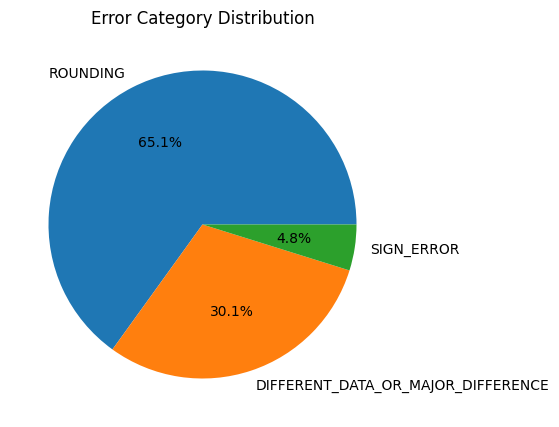

In [553]:
import pandas as pd
import matplotlib.pyplot as plt

# Suppose your DataFrame is named 'df'
# and has a column called 'answer_error_category'

# 1. Count per category
category_counts = llm_exp_train_df['answer_error_category'].value_counts(dropna=False)
print(category_counts)



# 2. Pie chart
plt.figure(figsize=(5, 5))
category_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Error Category Distribution')
plt.ylabel('')  # hide the default label
plt.show()


In [560]:
sampled_df = (
    llm_exp_train_df
    .groupby("answer_error_category", observed=False)  # or observed=True, as you prefer
    .head(15)  # Up to 5 rows per category
    .loc[:, ["question", "answer_error_category", "gold_answer", "clean_gold_answer", "model_answer"]]
)

# Sort by the category column so rows are grouped visually
sampled_df = sampled_df.sort_values(by="answer_error_category")

sampled_df
   


,question,answer_error_category,gold_answer,clean_gold_answer,model_answer
11,what percent of system energy's receivable from the money pool was replaced by a note receivable from entergy new orleans?,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,42%,42.00,53.33
1,what portion of the new sites acquired or constructed during 2010 is located outside united states?,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,87.9%,87.90,6865.0
67,what was the total amount of corporate and other expenses from 2015-2017?,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,415.6,415.60,400.4
65,"if vies were consolidated , what would the total minimum lease payments increase to , in millions?",DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,10282,10282.00,5801
64,what is the total net operating loss carryforwards?,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,2484034,2484034.00,2384034.00
5,what is the total return for every dollar invested in advanced auto parts in january 2009 and sold in january 2011?,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,0.96,0.96,1.96
63,for the= quarter ended march 31 what was the percent of the change in the stock price from the highest to the lowest,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,9.3%,9.30,8.50
10,"for acquired customer-related and network location intangibles , what is the expected annual amortization expenses , in millions?",DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,7.4,7.40,1.06
27,what is the percentage difference in the number of shares to be issued if the stock price closes at $ 11 compared to if it closes at $ 20?,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,278%,278.00,2277.78
55,what was the change in percentage of consolidated net sales from 2006 to 2008?,DIFFERENT_DATA_OR_MAJOR_DIFFERENCE,73%,73.00,10.06


# Re-run based on information from LLM reasoning and cateforisation, we can further improve prompts



In [562]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [564]:
from src.answer_prompt.few_shot import ANSWER_FEW_SHOT_PROMPT

# 1. 'process_records' creates the dataframe and columns 
improved_prompt_train_df = process_records(
    records=train_data[:10],
    system_prompts=ANSWER_FEW_SHOT_PROMPT ,
    model_name=gpt_4o,
    prompt_style="few-shot",
    table_key="html_table",
    model_pred_col_name="model_answer" # new column being added from model predictions 
)

ImportError: cannot import name 'ANSWER_FEW_SHOT_PROMPT' from 'src.answer_prompt.few_shot' (/Users/keshansharp/Tomoro_assignment/project/src/answer_prompt/few_shot.py)

In [ ]:
improved_prompt_train_df.head(10)

In [ ]:
# 2. add_local_metric_column - e.g. row_exact_match (row-level analysis) 
#   It creates a new column that you want to eval which you can choose in the param 'new_col_name'

train_df = add_local_metric_column(
    df= train_df,
    metric_func=float_row_exact_match, # Add chosen metric - row level exact match 
    gold_col="clean_gold_answer",
    pred_col="model_answer",
    new_col_name="answer_exact_match" # This is the name of the new column that is created based on the gold vs pred. 
    # Exact match here is just a basic exact string match which is using the row_exact_match function
)
# train_df.head(2)

In [ ]:
# 3. Eval at aggreate level to see performance
print(exact_match_score(train_df, "answer_exact_match"))
train_df.head(2)

In [ ]:
%load_ext autoreload
%autoreload 2

# 8. We have established evaluation metrics and an understanding of how to improve them via prompting on the answer 
---
- We have baseline metrics utilising gpt-4o. We have tested the  evaluation metric:
1. Answer - Exact Match: html table vs non-html table - html showed a slight improved performance of ..
---

## Insights 
- These are baselines with weak prompts, meaning little guidance and very vague. The purpose of which was to see how the models perform at baseline as they are improving all the time. 

### Gathering insights from LLM 
- I had the LLM run through and categorise the types of errors that it see's. The purpose of which is to guide me in creating better prompts or perhaps given more time change pre-processing.


### Prompt Engineer techniques:
- 1. ReAct - This template was created referring to the errors identified in previous experiments.
- 2. CoT - This template was created referring to the errors identified in previous experiments.


## Experiment 2: Run & Result - Accuracy Exact Match Score = (0/208) 0% which is surprising. 

### IT seems to be making the final mistake of multiplying at the final answer by 100 to convert to a percentage. Therefore exact match might not be best here. I'll go for a more semantically focused answer which will be rated from 0-1. 

### Must - Prompt engineer - ReAct and CoT to get improvement & Ask model to judge if sum is correct based on string info and points sytem. 


### Nice to have - use a reasoning model 

# Exact Match of Answer and Program Limitations 

- Exact match can be overly strict as there is no room for margin of tolerance e.g. gold answer is 11 and model answer is 10.99. Give it is a financial dataset this could still be important. For example, if this is a percentage then 10.99% of 1 million is £109,900 and 11% is £110,000, a difference of £100, if this kind of error is cumulative across different responses it will quickly add up to large amount therefore exact match is considered a good metric to keep.

# 9. Improving Model Performance through further Prompt Engineering: CoT Vs ReAct 

In [182]:
from src.program_prompt.ReACT_style import v1_REACT_PROGRAM_SYSTEM_PROMPT
from src.program_prompt.CoT_style import V1_COT_PROGRAM_SYSTEM_PROMPT 

In [183]:
# train_filtered
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
# 1. 'process_records' creates the dataframe and columns 
train_df_exp3 = process_records(
    records=train_data[:1],
    system_prompts=V1_COT_PROGRAM_SYSTEM_PROMPT,
    model_name=gpt_4o,
    prompt_style="CoT",
    table_key="html_table",
    model_pred_col_name="model_program_prediction" # new column being added from model predictions 
)

train_df_exp3.head(2)

,id,question,gold_answer,program,table,html_table,model,prompt_style,prompt,model_program_prediction
0,Single_IP/2013/page_65.pdf-1,what was the percentage change in the asian consumer packaging net sales in 2013,32.5%,"subtract(1.1, 830), divide(#0, 830)","[[in millions, 2013, 2012, 2011], [sales, $ 5650, $ 6040, $ 6630], [operating profit, -389 ( 389 ), 22, 34]]",<table>\n <thead>\n <tr>\n <th>in millions</th>\n <th>2013</th>\n <th>2012</th>\n <th>2011</th>\n </tr>\n </thead>\n <tbody>\n <tr><td>sales</td><td>$ 5650</td><td>$ 6040</td><td>$ 6630</td></tr>\n <tr><td>operating profit</td><td>-389 ( 389 )</td><td>22</td><td>34</td></tr>\n </tbody>\n</table>,gpt-4o,CoT,"{'system_prompt': 'You are a helpful financial analysis assistant. You will receive data that contains: 1) A 'PRE TEXT' section (textual narrative) 2) A 'POST TEXT' section (further textual discussion) 3) A HTML TABLE section {table} Your task: 1) Read the DATA carefully. 2) Rewrite the QUESTION in your own words. 3) Show your chain-of-thought reasoning. This is your step-by-step logic. 4) Finally, produce a 'Program:' line with the DSL steps needed to calculate the numeric answer. The DSL format uses operations like: subtract(a,b) add(a,b) multiply(a,b) divide(a,b) where each new operation references the previous result with #0, #1, etc. Example output might look like: Thought: Let me see... Program: subtract(7525,7344), divide(#0,7344)n ---------- DATA: === PRE TEXT === {pre_text} === POST TEXT === {post_text} === HTML TABLE === {table} Only provide answer>.'}","Rewritten Question: What was the percentage change in net sales for Asian consumer packaging from 2012 to 2013?\n\nThought: \n1. Identify the net sales figures for Asian consumer packaging in 2013 and 2012.\n2. The net sales for 2013 is given as $1.1 billion and for 2012 as $830 million.\n3. Calculate the change in sales by subtracting the 2012 figure from the 2013 figure.\n4. Divide the change in sales by the 2012 figure to find the percentage change.\n5. Multiply by 100 to convert the result into a percentage.\n\nProgram: subtract(1100, 830), divide(#0, 830), multiply(#1, 100)"
